# `EmissionModel` Tutorial

Trey V. Wenger (c) September 2024

Here we demonstrate the basic features of the `EmissionModel` model. `EmissionModel` models 21-cm emission spectra like those obtained from typical ON - OFF observations.

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import caribou_hi
print("caribou_hi version:", caribou_hi.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.16.2
bayes_spec version: 1.6.3+4.ga230ddc.dirty
caribou_hi version: 1.0.0-staging+1.g238726f.dirty


## Simulating Data

To test the model, we must simulate some data. We can do this with `EmissionModel`, but we must pack a "dummy" data structure first. The model expects the observation to be named `"emission"`.

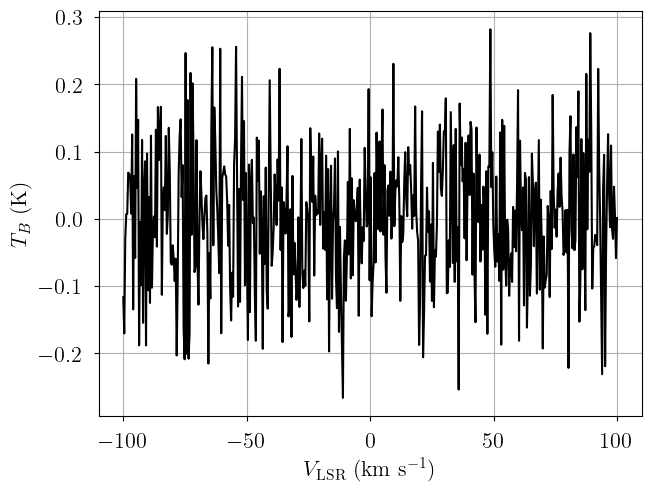

In [2]:
from bayes_spec import SpecData

# spectral axes definition
velo_axis = np.linspace(-100.0, 100.0, 500) # km s-1

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms = 0.1 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
emission = rms * np.random.randn(len(velo_axis))

dummy_data = {"emission": SpecData(
    velo_axis,
    emission,
    rms,
    xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
    ylabel=r"$T_B$ (K)",
)}

# Plot dummy data
fig, ax = plt.subplots(layout="constrained")
ax.plot(dummy_data["emission"].spectral, dummy_data["emission"].brightness, "k-")
ax.set_xlabel(dummy_data["emission"].xlabel)
_ = ax.set_ylabel(dummy_data["emission"].ylabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the likelihood.

In [3]:
from caribou_hi import EmissionModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 2
model = EmissionModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    bg_temp = 3.77, # assumed background temperature (K)
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_NHI = [20.0, 0.5], # mean and width of log10(NHI) prior (cm-2)
    prior_log10_nHI = [1.0, 0.5], # mean and width of log10(nHI) prior (cm-3)
    prior_log10_tkin = [2.0, 0.5], # mean and width of log10(kinetic temp) prior (K)
    prior_log10_n_alpha = [-6.0, 0.5], # mean and width of log10(n_alpha) prior (cm-3)
    prior_log10_larson_linewidth = [0.2, 0.05], # mean and width of log10(larson_linewidth) prior (km s-1)
    prior_larson_power = [0.4, 0.05], # mean and width of larson_power prior
    prior_velocity = [0.0, 2.0], # mean and width of velocity prior (km/s)
    prior_rms_emission = 0.1, # width of emission rms (K) prior
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

In [4]:
# Evaluate likelihood for given model parameters
sim_params = {
    "log10_NHI": np.array([20.0, 21.0, 20.5]),
    "log10_nHI": np.array([2.0, 0.0, 0.5]),
    "log10_tkin": np.array([2.5, 4.0, 3.5]),
    "log10_n_alpha": np.array([-6.0, -5.0, -6.0]),
    "log10_larson_linewidth": np.array([0.15, 0.2, 0.25]),
    "larson_power": np.array([0.5, 0.3, 0.3]),
    "velocity": np.array([0.0, -5.0, 5.0]),
    "rms_emission": rms,
    "baseline_emission_norm": np.array([-1.0, 2.0, 5.0])
}
emission = model.model["emission"].eval(sim_params)
data = {"emission": SpecData(
    velo_axis,
    emission,
    rms,
    xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
    ylabel=r"$T_B$ (K)",
)}

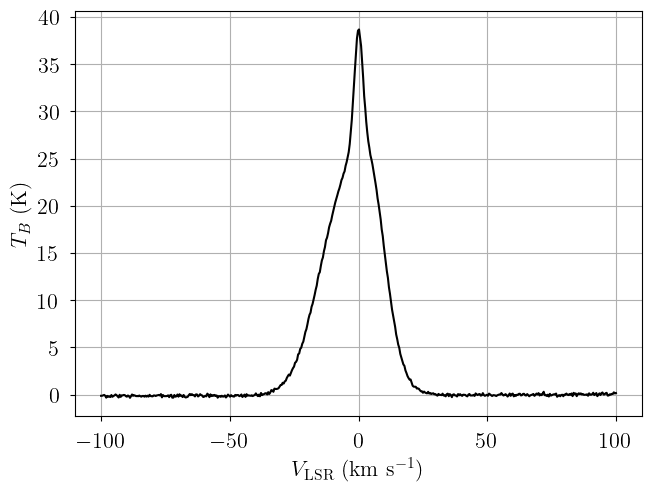

In [5]:
# Plot data
fig, ax = plt.subplots(layout="constrained")
ax.plot(data["emission"].spectral, data["emission"].brightness, "k-")
ax.set_xlabel(data["emission"].xlabel)
_ = ax.set_ylabel(data["emission"].ylabel)

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `EmissionModel`. Here we create a new model with the simulated data.

In [6]:
# Initialize and define the model
model = EmissionModel(
    data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    bg_temp = 3.77, # assumed background temperature (K)
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_NHI = [20.0, 0.5], # mean and width of log10(NHI) prior (cm-2)
    prior_log10_nHI = [1.0, 0.5], # mean and width of log10(nHI) prior (cm-3)
    prior_log10_tkin = [2.0, 0.5], # mean and width of log10(kinetic temp) prior (K)
    prior_log10_n_alpha = [-6.0, 0.5], # mean and width of log10(n_alpha) prior (cm-3)
    prior_log10_larson_linewidth = [0.2, 0.05], # mean and width of log10(larson_linewidth) prior (km s-1)
    prior_larson_power = [0.4, 0.05], # mean and width of larson_power prior
    prior_velocity = [0.0, 2.0], # mean and width of velocity prior (km/s)
    prior_rms_emission = 0.1, # width of emission rms (K) prior
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

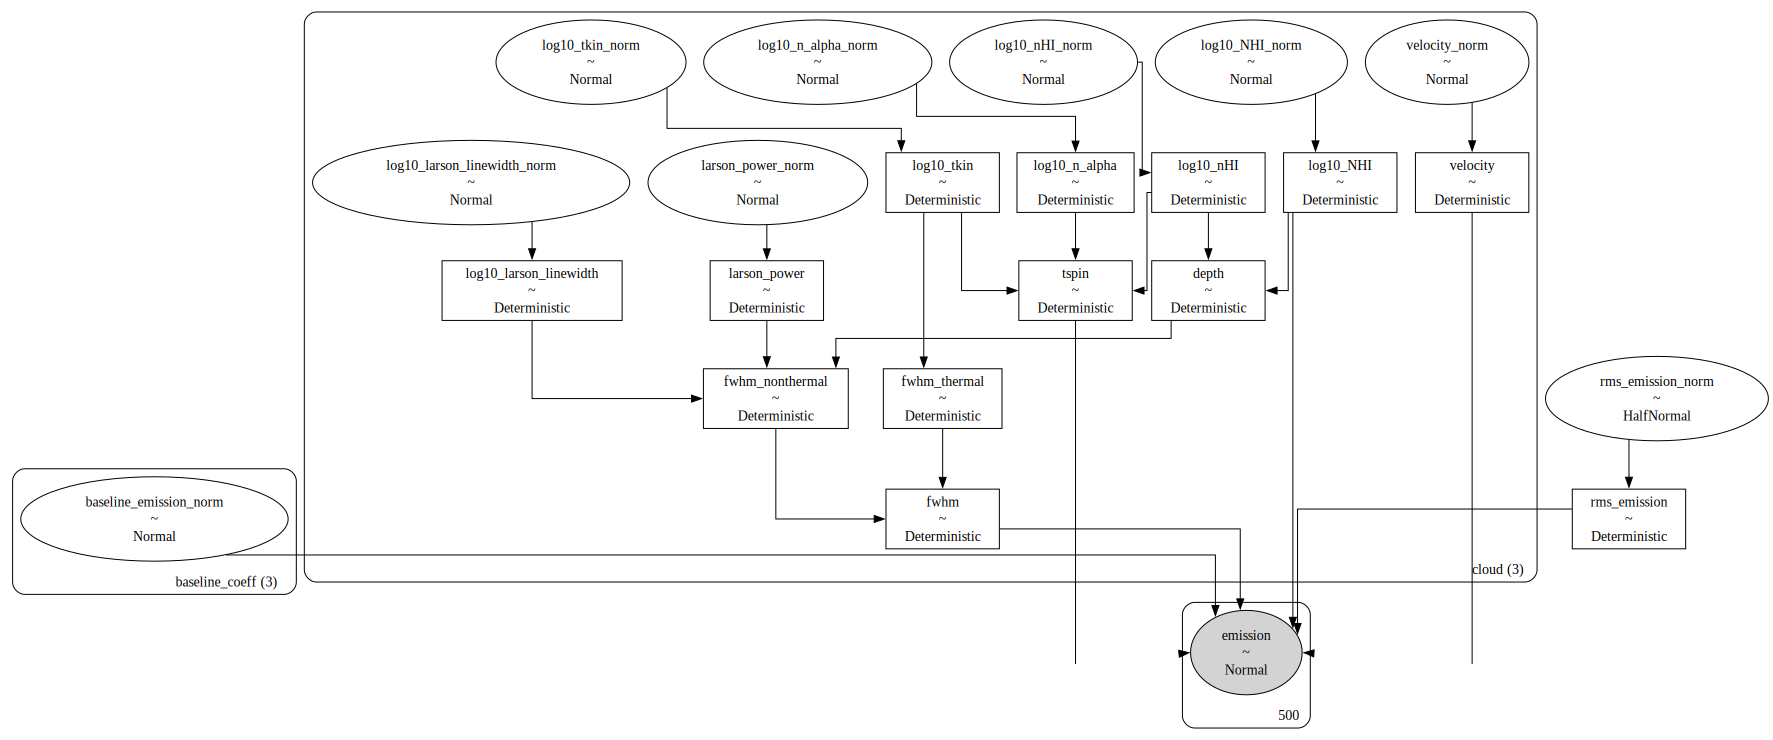

In [7]:
# Plot model graph
model.graph().render('emission_model', format='png')
model.graph()

In [8]:
# model string representation
print(model.model.str_repr())

     baseline_emission_norm ~ Normal(0, <constant>)
             log10_NHI_norm ~ Normal(0, 1)
             log10_nHI_norm ~ Normal(0, 1)
            log10_tkin_norm ~ Normal(0, 1)
         log10_n_alpha_norm ~ Normal(0, 1)
log10_larson_linewidth_norm ~ Normal(0, 1)
          larson_power_norm ~ Normal(0, 1)
              velocity_norm ~ Normal(0, 1)
          rms_emission_norm ~ HalfNormal(0, 1)
                  log10_NHI ~ Deterministic(f(log10_NHI_norm))
                  log10_nHI ~ Deterministic(f(log10_nHI_norm))
                 log10_tkin ~ Deterministic(f(log10_tkin_norm))
              log10_n_alpha ~ Deterministic(f(log10_n_alpha_norm))
     log10_larson_linewidth ~ Deterministic(f(log10_larson_linewidth_norm))
               larson_power ~ Deterministic(f(larson_power_norm))
                   velocity ~ Deterministic(f(velocity_norm))
                      tspin ~ Deterministic(f(log10_tkin_norm, log10_n_alpha_norm, log10_nHI_norm))
               fwhm_thermal ~ Determini

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [baseline_emission_norm, emission, larson_power_norm, log10_NHI_norm, log10_larson_linewidth_norm, log10_nHI_norm, log10_n_alpha_norm, log10_tkin_norm, rms_emission_norm, velocity_norm]


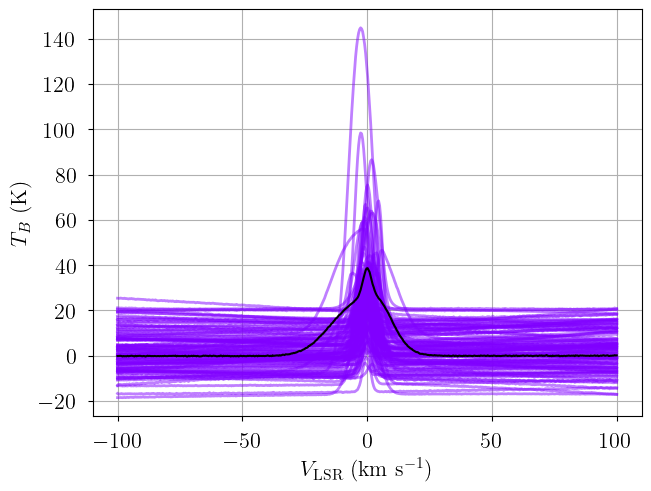

In [9]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [11]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 6700
Interrupted at 6,699 [6%]: Average Loss = 1.259e+05


Runtime: 0.19 minutes


In [12]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_emission_norm[0],-0.455,0.001,-0.457,-0.453,0.000,0.000,990.0,951.0,NaN
baseline_emission_norm[1],0.022,0.003,0.017,0.026,0.000,0.000,1008.0,912.0,NaN
baseline_emission_norm[2],-0.024,0.017,-0.055,0.008,0.001,0.000,984.0,937.0,NaN
depth[0],1.945,0.072,1.822,2.090,0.002,0.002,966.0,1016.0,NaN
depth[1],56.508,0.345,55.829,57.114,0.011,0.008,995.0,983.0,NaN
depth[2],111.956,0.565,110.976,113.112,0.018,0.013,969.0,872.0,NaN
fwhm[0],3.754,0.048,3.669,3.850,0.002,0.001,881.0,983.0,NaN
fwhm[1],15.521,0.069,15.394,15.648,0.002,0.002,917.0,974.0,NaN
fwhm[2],22.558,0.098,22.371,22.735,0.003,0.002,1005.0,812.0,NaN
fwhm_nonthermal[0],2.471,0.060,2.348,2.572,0.002,0.001,1014.0,1065.0,NaN


Sampling: [emission]


Output()

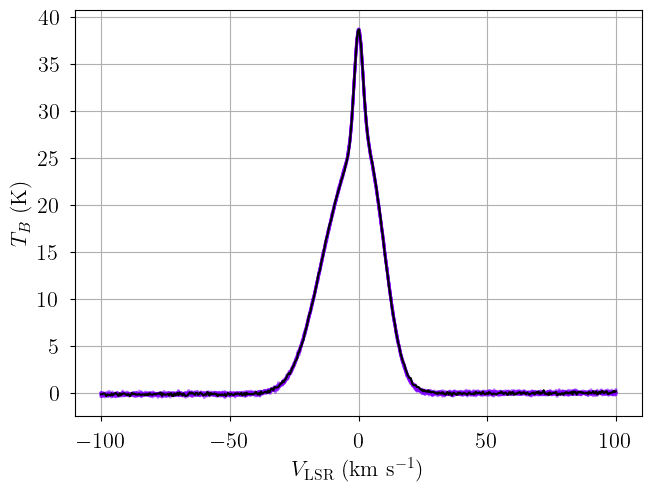

In [13]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [14]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 6700
Interrupted at 6,699 [6%]: Average Loss = 1.259e+05
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_emission_norm, log10_NHI_norm, log10_nHI_norm, log10_tkin_norm, log10_n_alpha_norm, log10_larson_linewidth_norm, larson_power_norm, velocity_norm, rms_emission_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1529 seconds.


There were 13 divergences in converged chains.
Runtime: 26.11 minutes


In [15]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


Check that the effective sample sizes are large and the covergence statistic `r_hat` is close to 1! If not, you may have to increase the number of tuning steps (`tune=2000`) or the NUTS acceptance rate (`target_accept=0.9`).

In [16]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"])
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_emission_norm[0],-0.459,0.001,-0.462,-0.457,0.000,0.000,1710.0,2604.0,1.0
baseline_emission_norm[1],0.021,0.002,0.018,0.025,0.000,0.000,2928.0,2854.0,1.0
baseline_emission_norm[2],0.055,0.021,0.017,0.095,0.001,0.000,1568.0,2415.0,1.0
depth[0],2.335,2.249,0.092,5.928,0.058,0.041,1310.0,2085.0,1.0
depth[1],74.159,55.512,13.513,171.501,1.499,1.060,986.0,694.0,1.0
depth[2],253.967,187.394,48.130,560.326,4.796,3.392,1531.0,1987.0,1.0
fwhm[0],3.815,0.039,3.742,3.887,0.001,0.001,1391.0,1574.0,1.0
fwhm[1],13.653,0.203,13.265,14.008,0.007,0.005,961.0,1766.0,1.0
fwhm[2],24.234,0.121,24.012,24.465,0.002,0.002,2594.0,3089.0,1.0
fwhm_nonthermal[0],2.252,0.575,1.228,3.184,0.018,0.013,894.0,1068.0,1.0


We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [emission]


Output()

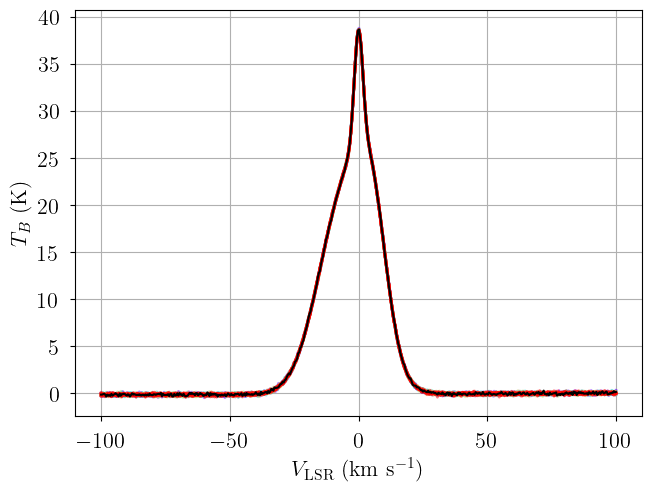

In [17]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

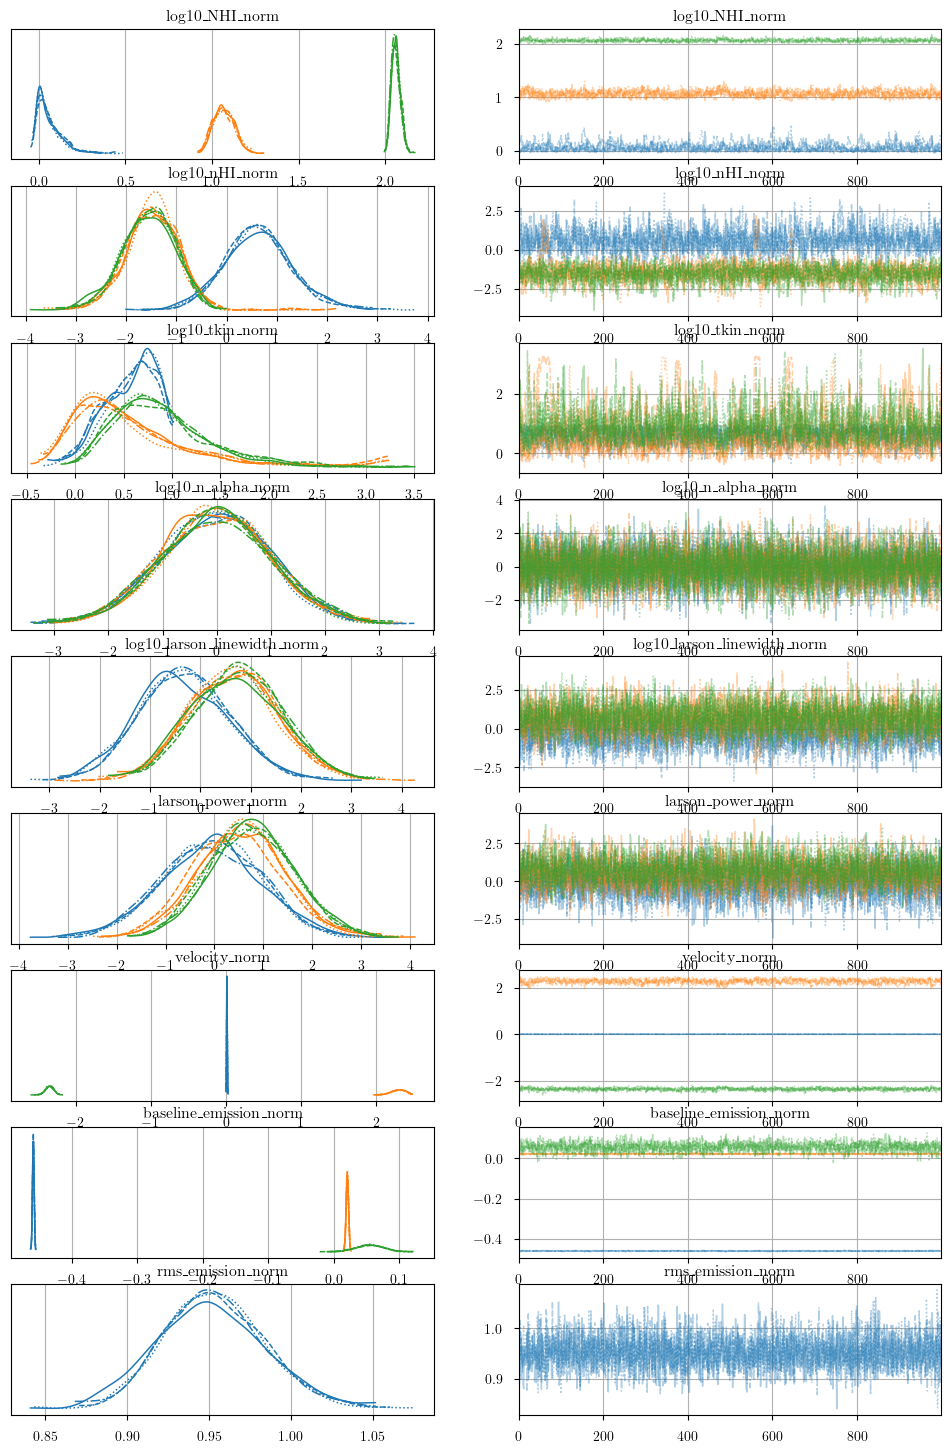

In [18]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

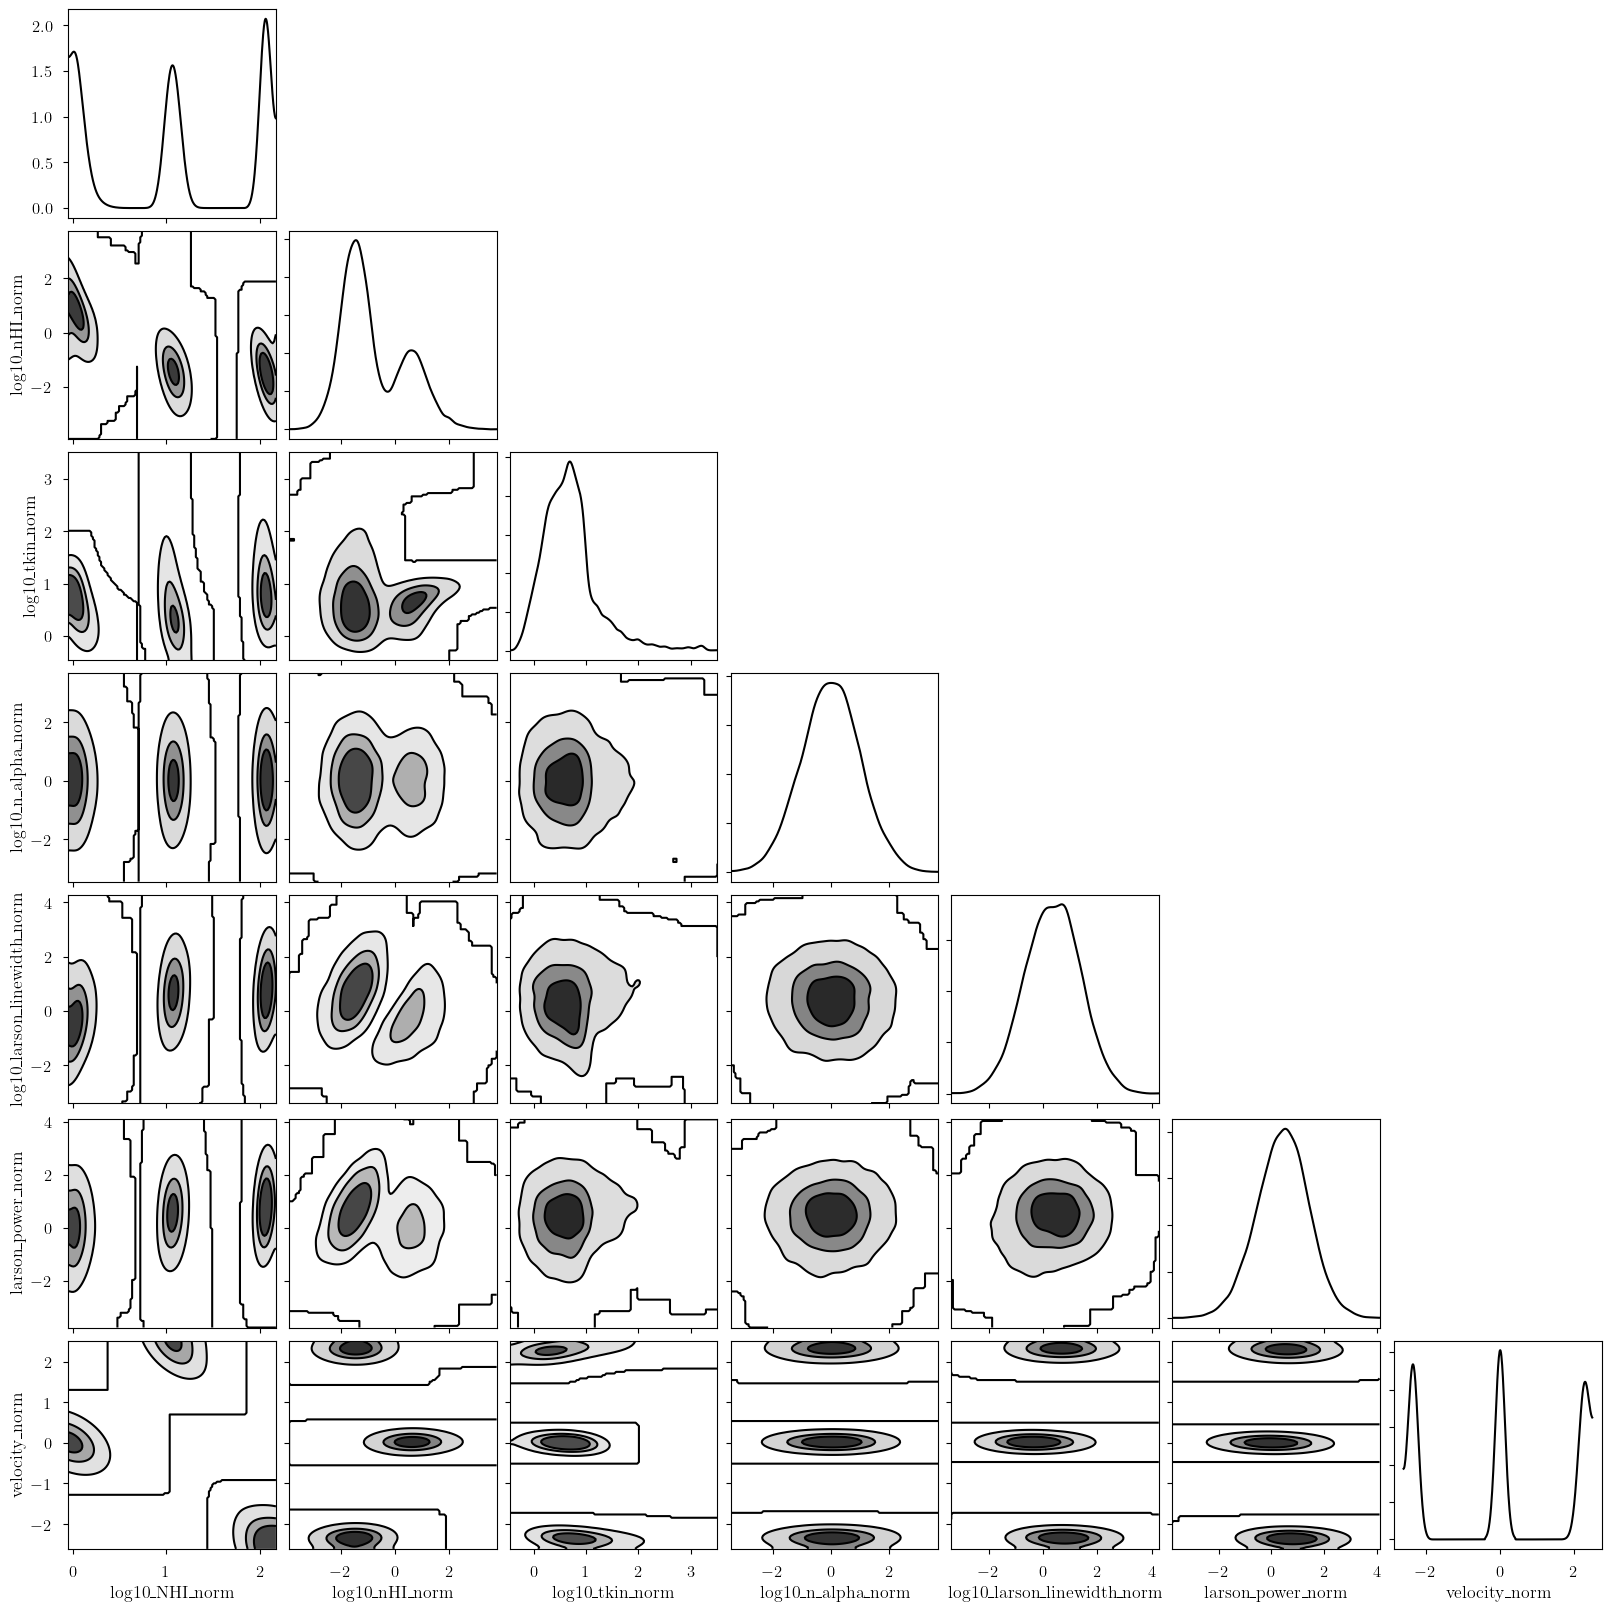

In [19]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud.

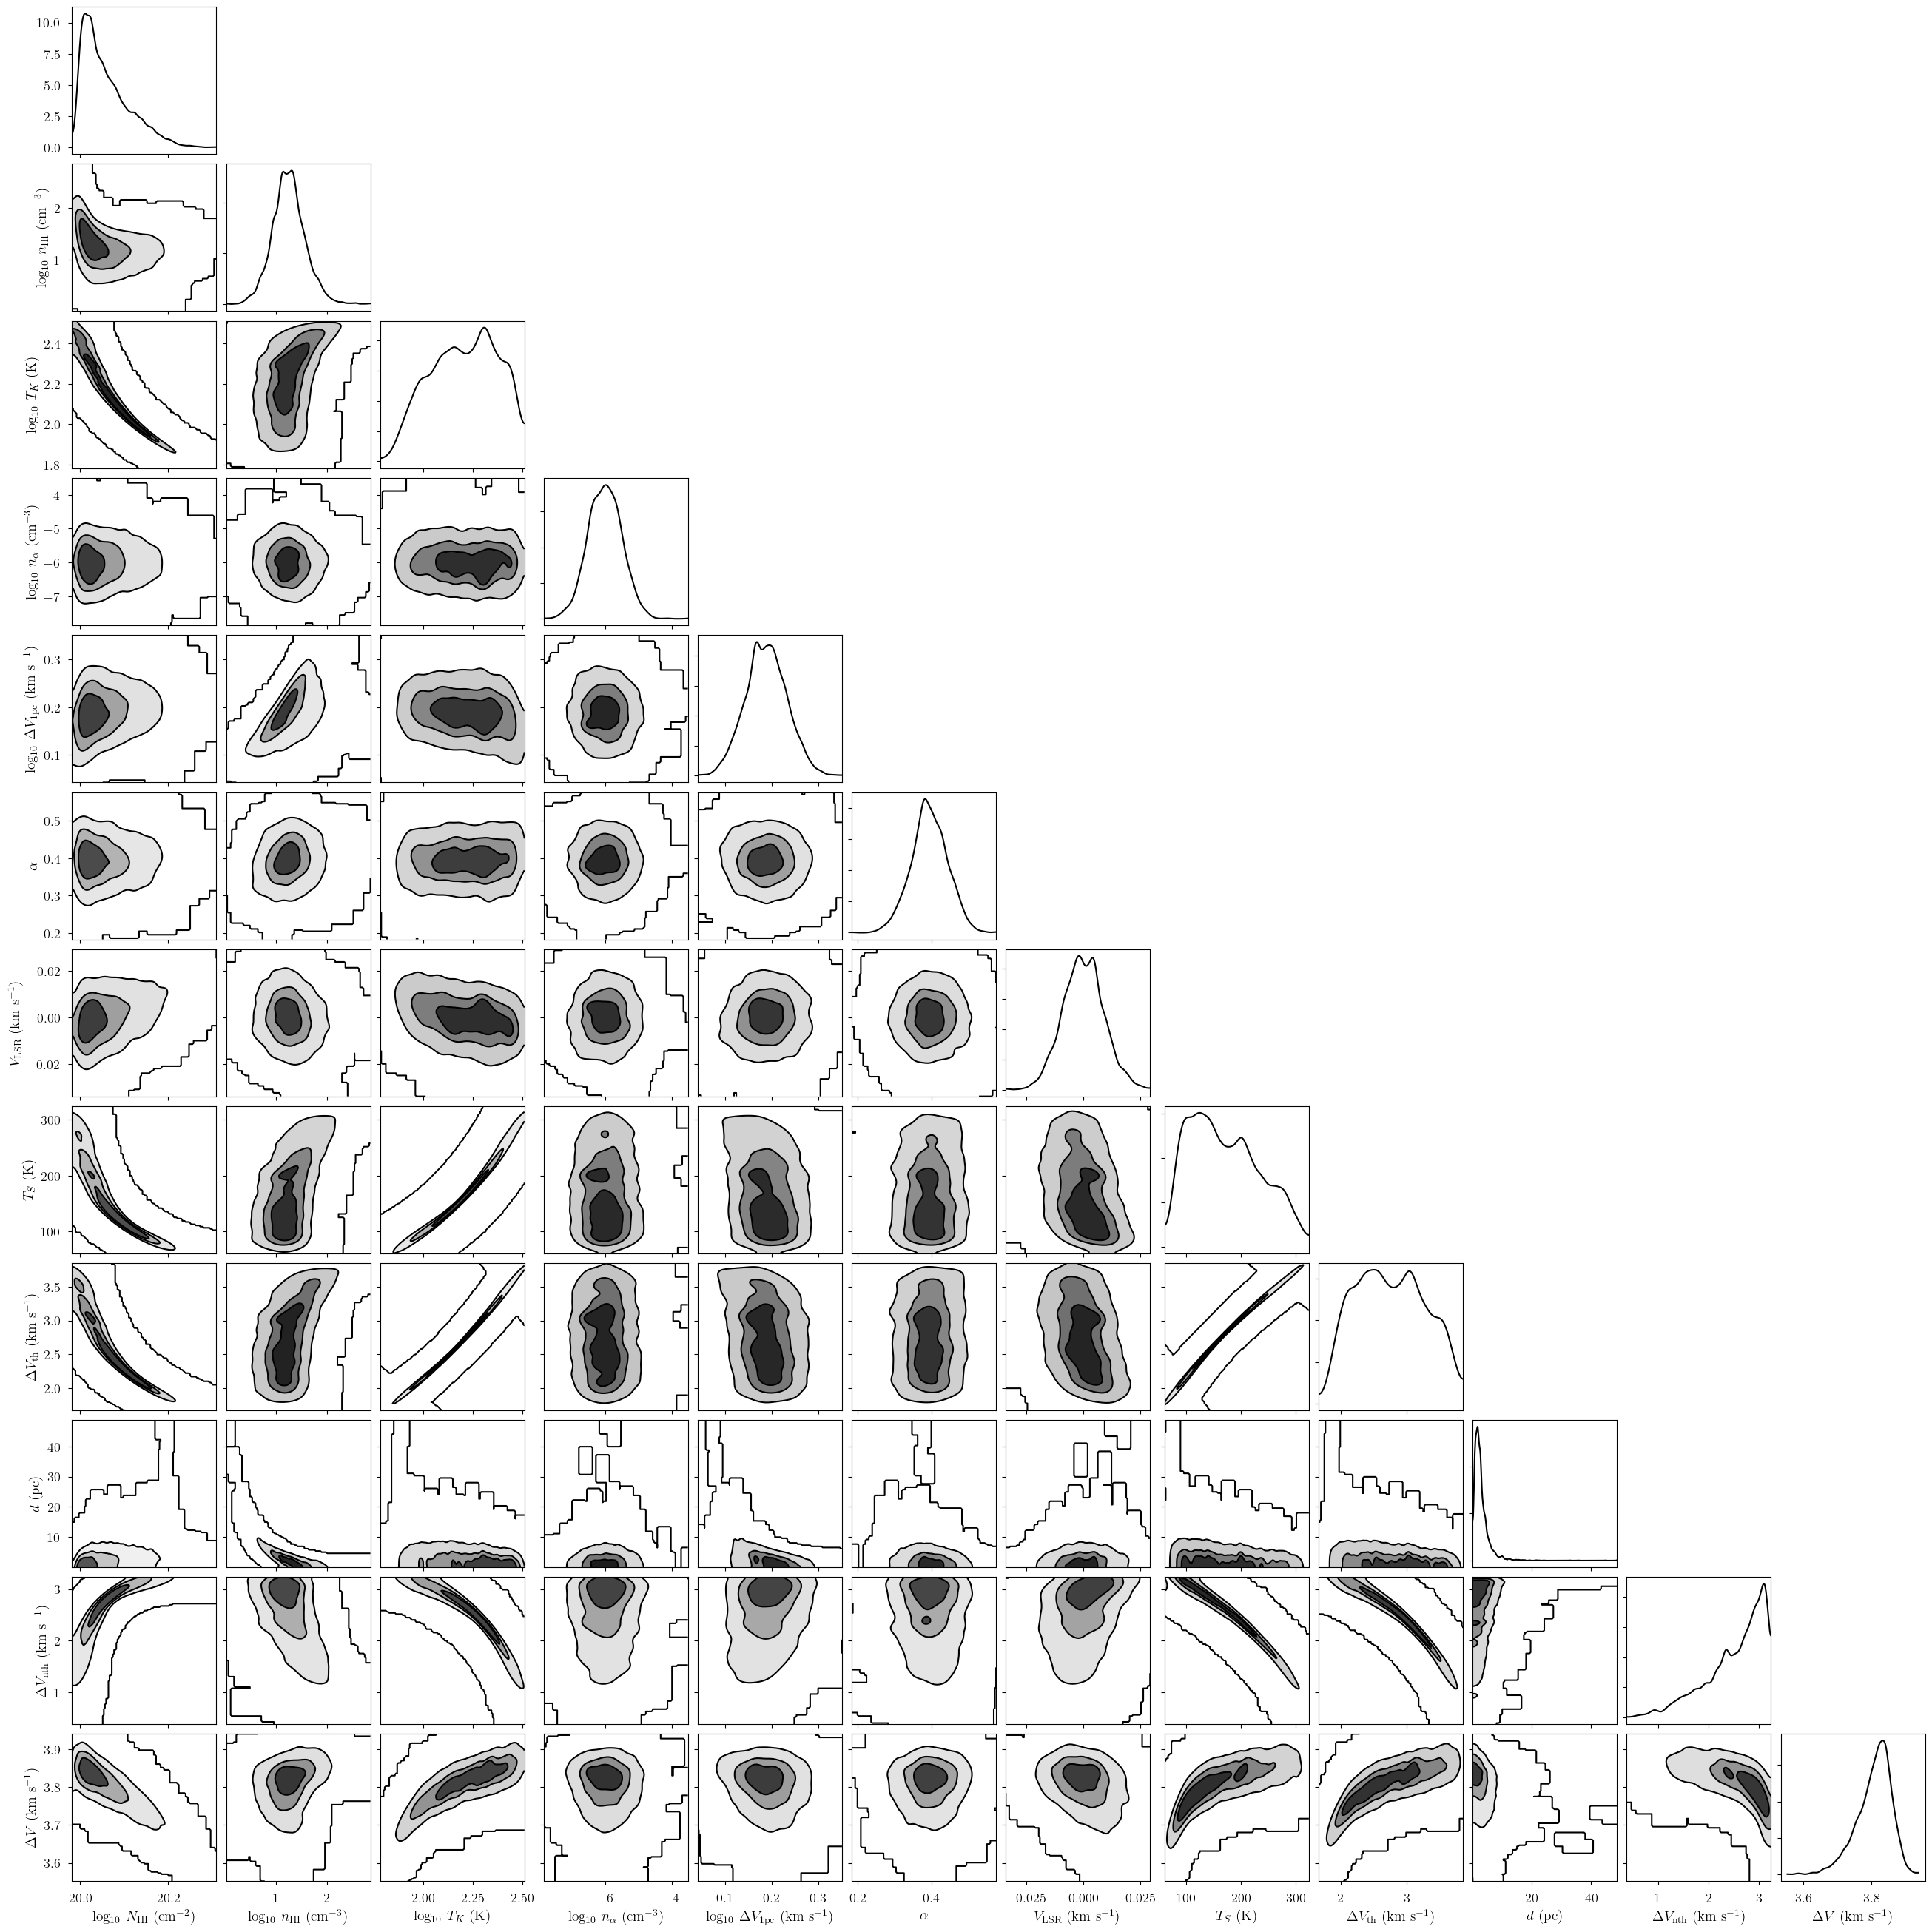

In [46]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [20]:
point_stats = az.summary(model.trace.solution_0, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: 704.7953104563971


,mean,sd,hdi_16%,hdi_84%
baseline_emission_norm[0],-0.459,0.001,-0.461,-0.458
baseline_emission_norm[1],0.021,0.002,0.019,0.023
baseline_emission_norm[2],0.055,0.021,0.038,0.079
depth[0],2.335,2.249,0.286,2.601
depth[1],74.159,55.512,25.430,88.760
depth[2],253.967,187.394,68.680,283.103
fwhm[0],3.815,0.039,3.786,3.857
fwhm[1],13.653,0.203,13.473,13.883
fwhm[2],24.234,0.121,24.131,24.369
fwhm_nonthermal[0],2.252,0.575,1.932,3.036


These emission-only data are able to provide meaningful constraints on the HI column density, but not on the volume density and spin temperature.